In [1]:
import numpy as np, torch, dill, time, os
from Ctubes.curve_parametrizations import trefoil_parameterization
from Ctubes.geometry_utils import rotate_about_axis, compute_cross_section_radii, regular_polygon, get_bisecting_plane_normals_with_symmetry
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_exact, get_pairings_all
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 9: Trefoils

## #1: Curve Optimzation ($\varphi^* = 240$˚)

In [128]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig9_trefoil_240deg_curve")

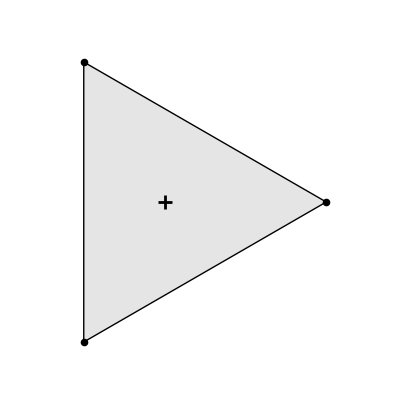

In [129]:
# Generatrix: regular N-gon
N = 3
tube_radius = 0.3
generatrix_2d = regular_polygon(N, tube_radius)

fig, ax = plot_generatrix(generatrix_2d)

In [130]:
# Directrix: trefoil knot
closed_curve = True
K_per_base_curve = 5
n_fold_symm = 3
K = K_per_base_curve * n_fold_symm + 1
K_to_M_factor = 13
M = K_to_M_factor * (K - 1) + 1

# Define the spline
ts_disc_curve = torch.linspace(0.0, 2.0 * PI, K)
cps_ref = trefoil_parameterization(ts_disc_curve)

In [131]:
# Define symmetry transforms
z_axis = torch.tensor([0.0, 0.0, 1.0], dtype=TORCH_DTYPE)
symmetry_transforms = [
    lambda pts: rotate_about_axis(pts, z_axis, torch.tensor(4*PI/3)),
    lambda pts: rotate_about_axis(pts, z_axis, torch.tensor(8*PI/3)),
]

# Select one third of the curve
K = (K - 1) // n_fold_symm + 1
M = (M - 1) // n_fold_symm + 1
cps_ref = cps_ref[:K]

In [132]:
# C-tube
directrix = Directrix(cps_ref, M, symmetry_transforms=symmetry_transforms)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

plane_normals = get_bisecting_plane_normals_with_symmetry(directrix)

tube = CTube(
    directrix, generatrix, plane_normals,
    symmetry_transforms=symmetry_transforms
)

In [133]:
# Pickle C-Tube
pkl_file = os.path.join(paths["output_opt"], "tube_init.pkl")
dill.dump(tube, open(pkl_file, "wb"))

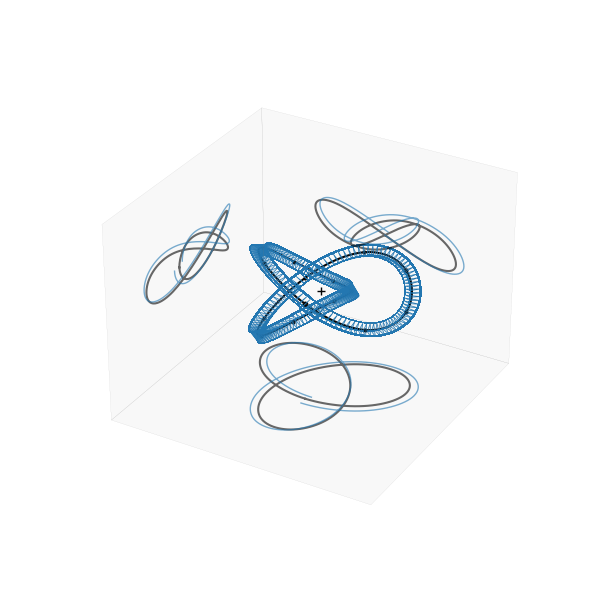

In [134]:
fig, ax = tube.plot_3d()

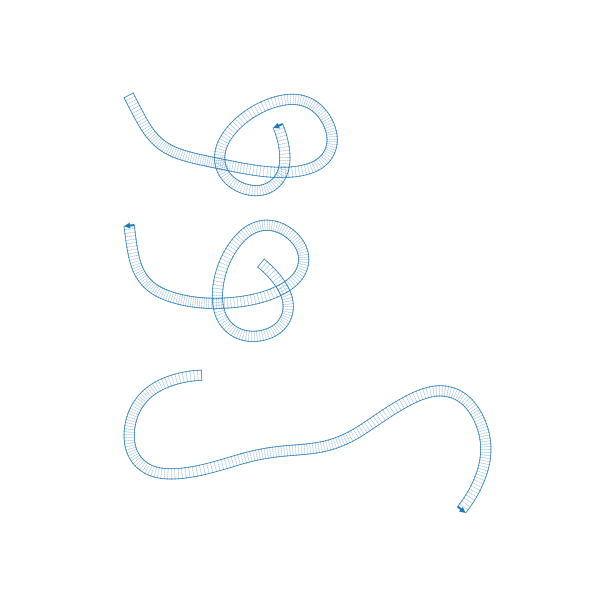

In [135]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [136]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': 1.0 / directrix.aabb_diagonal_length() ** 2,
    'join_ends': 1e2 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_all(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [138]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000000000
join_ends                               : 0.1565578657
smooth_plane_normal_diffs               : 0.0000255010
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(0.1566)

In [139]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []
dofs = opt_prob.get_dof_indices_cps()
fixed_indices += dofs[:3] + dofs[-3:]  # fix endpoints
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 6 parameters.


In [140]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         6 variables are exactly at the bounds

At iterate    0    f=  1.56583D-01    |proj g|=  2.67067D+00

At iterate    1    f=  4.65532D-03    |proj g|=  4.90410D-01

At iterate    2    f=  1.20850D-04    |proj g|=  6.37804D-02

At iterate    3    f=  4.54391D-05    |proj g|=  1.51513D-03

At iterate    4    f=  4.53958D-05    |proj g|=  4.68685D-05

At iterate    5    f=  4.53943D-05    |proj g|=  1.31886D-04

At iterate    6    f=  4.53882D-05    |proj g|=  3.72130D-04

At iterate    7    f=  4.53666D-05    |proj g|=  8.88488D-04

At iterate    8    f=  4.53209D-05    |proj g|=  1.49641D-03

At iterate    9    f=  4.52218D-05    |proj g|=  2.04006D-03

At iterate   10    f=  4.50952D-05    |proj g|=  1.69258D-03

At iterate   11    f=  4.50540D-05    |proj g|=  7.49510D-04

At iterate   12    f=  4.50423D-05    |proj g|=  2.93053D-04

At iterate   13    f=  4.5

In [68]:
opt_prob.compute_objective(print_to_console=True)

tensor([1.3500e-01, 1.3499e-01, 1.5022e-09])
preserve_curve                          : 0.0000173324
join_ends                               : 0.0000003179
smooth_plane_normal_diffs               : 0.0000265586
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(4.4209e-05)

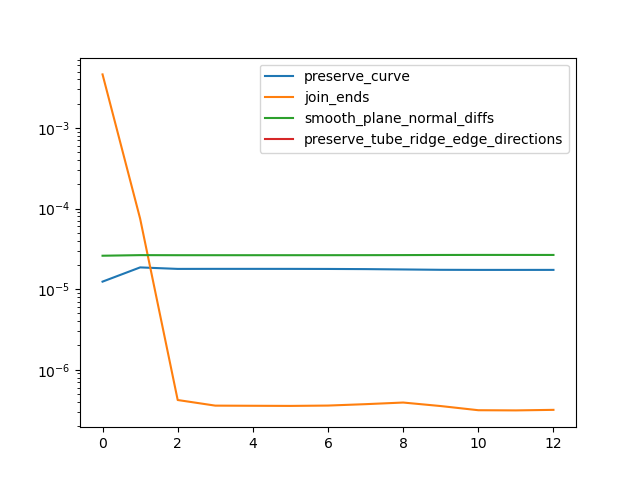

In [69]:
fig, ax = opt_prob.plot_objective_history()

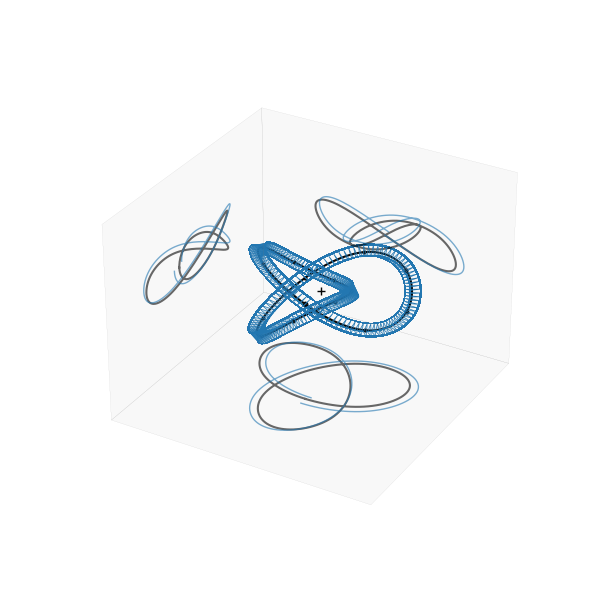

In [70]:
fig, ax = opt_prob.plot_3d()

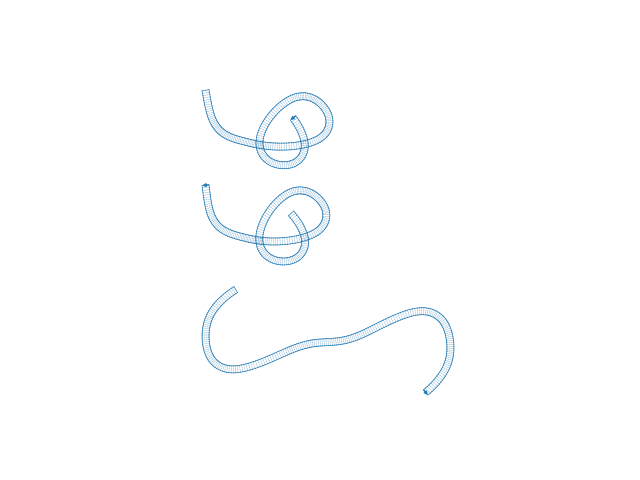

In [71]:
fig, ax = opt_prob.plot_unrolled_strips()

## #2: Curve Optimzation ($\varphi^* = 360$˚)

In [72]:
# Load pickled C-Tube
paths_load = setup_paths(get_name(), test_name="fig9_trefoil_240deg_curve")

pkl_file = os.path.join(paths_load["output_opt"], "tube_init.pkl")
tube = dill.load(open(pkl_file, "rb"))

In [73]:
paths = setup_paths(get_name(), test_name="fig9_trefoil_360deg_curve")

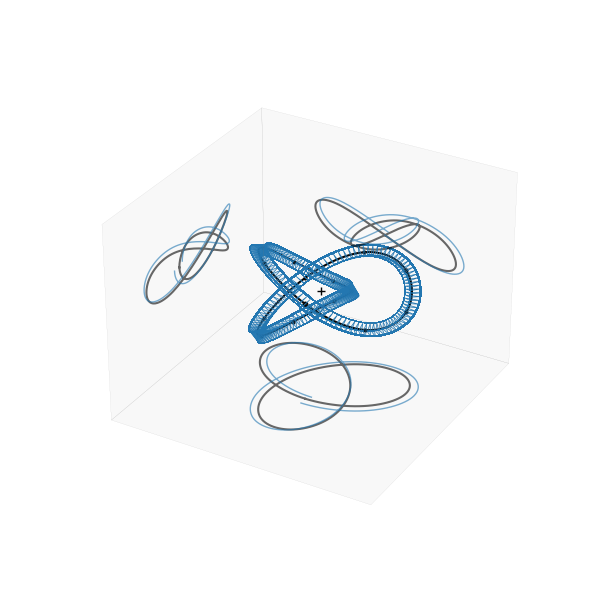

In [74]:
fig, ax = tube.plot_3d()

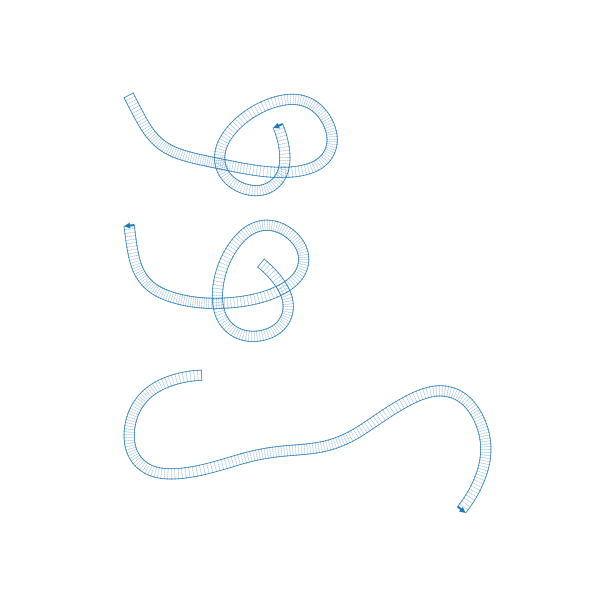

In [75]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [76]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': 1.0 / directrix.aabb_diagonal_length() ** 2,
    'join_ends': 1e3 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_exact(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights,
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [77]:
opt_prob.compute_objective(print_to_console=True)

tensor([0.1446])
preserve_curve                          : 0.0000000000
join_ends                               : 306.1003476188
smooth_plane_normal_diffs               : 0.0000247283
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(306.1004)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []
dofs = opt_prob.get_dof_indices_cps()
fixed_indices += dofs[:3] + dofs[-3:]  # fix endpoints
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 6 parameters.


In [49]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         6 variables are exactly at the bounds

At iterate    0    f=  3.06100D+02    |proj g|=  1.66109D+02

At iterate    1    f=  3.48833D-02    |proj g|=  7.30359D+00

At iterate    2    f=  3.54802D-03    |proj g|=  1.41228D-02

At iterate    3    f=  3.54785D-03    |proj g|=  2.81162D-03

At iterate    4    f=  3.54777D-03    |proj g|=  4.95621D-03

At iterate    5    f=  3.54719D-03    |proj g|=  2.17940D-02

At iterate    6    f=  3.54604D-03    |proj g|=  4.23364D-02

At iterate    7    f=  3.54277D-03    |proj g|=  7.93594D-02

At iterate    8    f=  3.53548D-03    |proj g|=  1.33665D-01

At iterate    9    f=  3.52187D-03    |proj g|=  2.03228D-01

At iterate   10    f=  3.49971D-03    |proj g|=  2.50961D-01

At iterate   11    f=  3.44957D-03    |proj g|=  2.67942D-01

At iterate   12    f=  3.36144D-03    |proj g|=  1.58645D-01

At iterate   13    f=  3.2

In [50]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0013161192
join_ends                               : 0.0000001631
smooth_plane_normal_diffs               : 0.0001288659
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(0.0014)

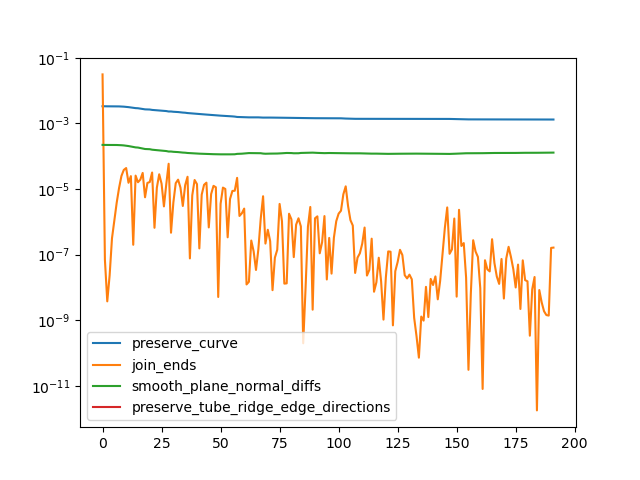

In [51]:
fig, ax = opt_prob.plot_objective_history()

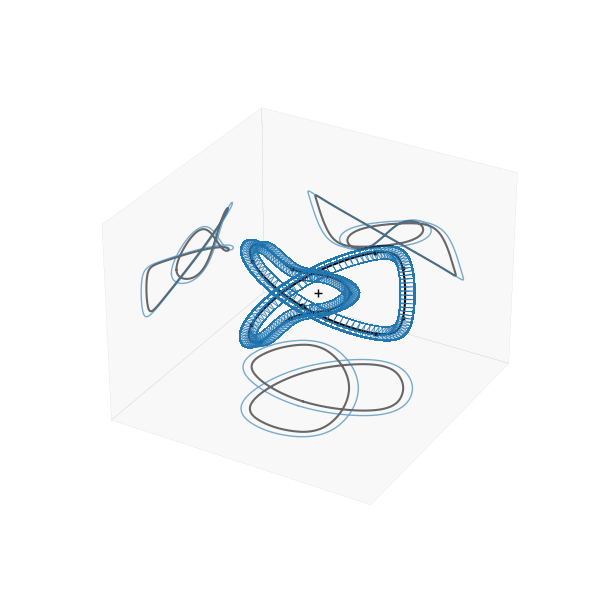

In [52]:
fig, ax = opt_prob.plot_3d()

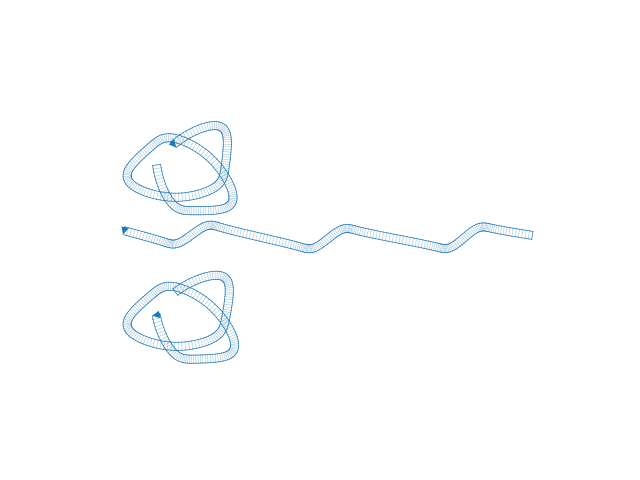

In [53]:
fig, ax = opt_prob.plot_unrolled_strips()

## #3: Plane Optimzation ($\varphi^* = 360$˚)

In [35]:
# Load pickled C-Tube
paths_load = setup_paths(get_name(), test_name="fig9_trefoil_240deg_curve")

pkl_file = os.path.join(paths_load["output_opt"], "tube_init.pkl")
tube = dill.load(open(pkl_file, "rb"))

In [36]:
paths = setup_paths(get_name(), test_name="fig9_trefoil_360deg_planes")

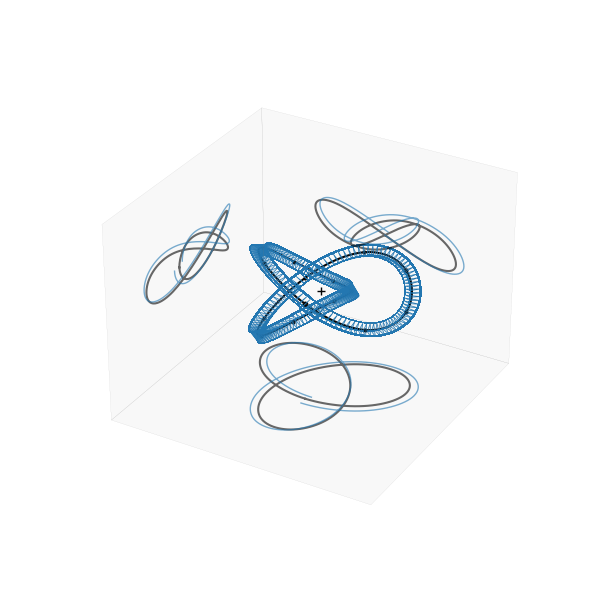

In [37]:
fig, ax = tube.plot_3d()

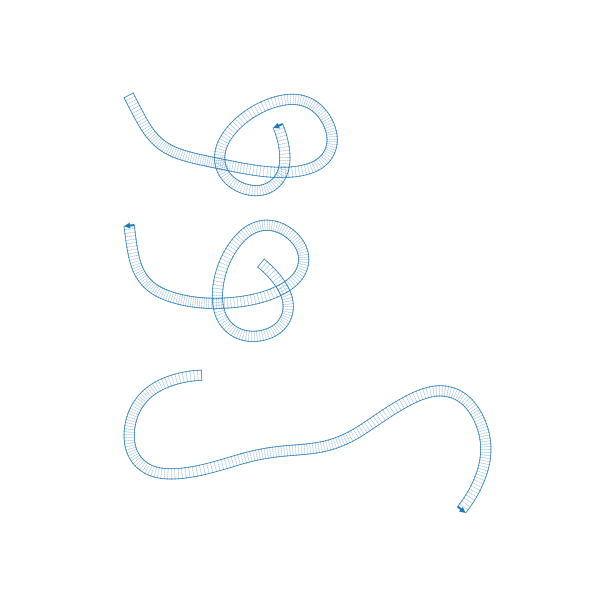

In [38]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [ ]:
# Set up optimization problem

opt_weights = {
    'join_ends': 1.0 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_exact(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)
opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(True)

In [41]:
opt_prob.compute_objective(print_to_console=True)

join_ends                               : 0.3061003476
smooth_plane_normal_diffs               : 0.0000247283
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000000000


tensor(0.3061)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [43]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          195     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06125D-01    |proj g|=  4.53333D-02

At iterate    1    f=  1.36248D-01    |proj g|=  1.46289D-02

At iterate    2    f=  9.98902D-02    |proj g|=  9.03177D-03

At iterate    3    f=  7.41114D-02    |proj g|=  1.58949D-02


 This problem is unconstrained.



At iterate    4    f=  6.32484D-02    |proj g|=  6.64851D-03

At iterate    5    f=  5.82591D-02    |proj g|=  6.47203D-03

At iterate    6    f=  5.34713D-02    |proj g|=  1.08770D-02

At iterate    7    f=  5.18033D-02    |proj g|=  8.08456D-03

At iterate    8    f=  4.96734D-02    |proj g|=  2.34844D-03

At iterate    9    f=  4.89600D-02    |proj g|=  1.44296D-03

At iterate   10    f=  4.79624D-02    |proj g|=  1.67772D-03

At iterate   11    f=  4.77435D-02    |proj g|=  2.70039D-03

At iterate   12    f=  4.75029D-02    |proj g|=  4.43623D-04

At iterate   13    f=  4.74810D-02    |proj g|=  4.70374D-04

At iterate   14    f=  4.74488D-02    |proj g|=  4.74902D-04

At iterate   15    f=  4.70880D-02    |proj g|=  1.36937D-03

At iterate   16    f=  4.36965D-02    |proj g|=  5.73917D-03

At iterate   17    f=  4.36495D-02    |proj g|=  6.35952D-03

At iterate   18    f=  4.06083D-02    |proj g|=  7.73639D-03

At iterate   19    f=  3.82637D-02    |proj g|=  8.83088D-03

At iter

In [44]:
opt_prob.compute_objective(print_to_console=True)

join_ends                               : 0.0000000004
smooth_plane_normal_diffs               : 0.0000272049
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000009207


tensor(2.8126e-05)

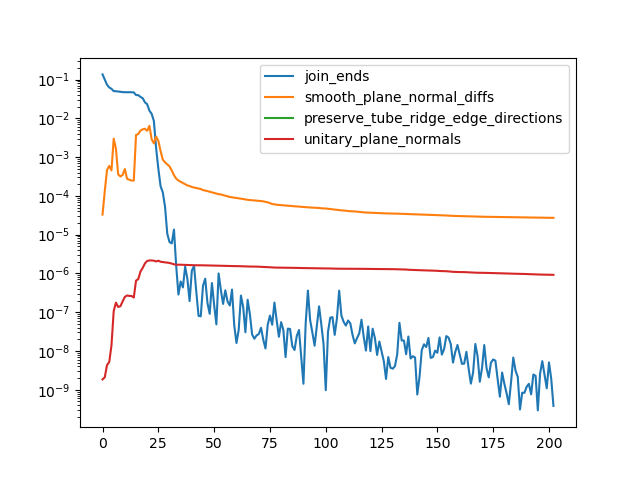

In [45]:
fig, ax = opt_prob.plot_objective_history()

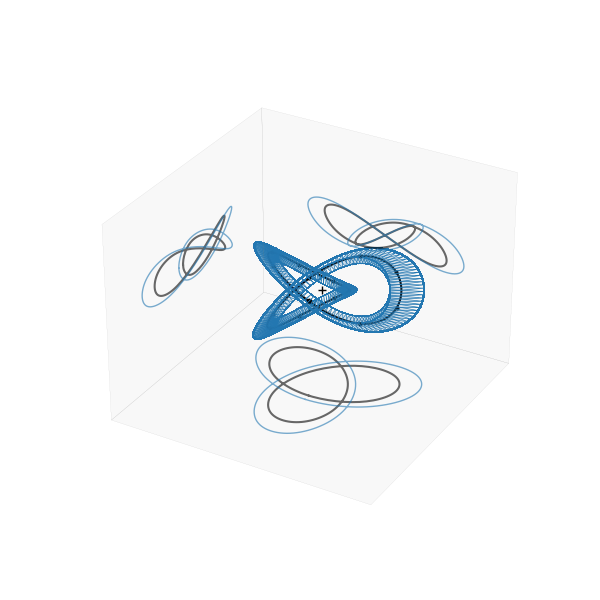

In [46]:
fig, ax = opt_prob.plot_3d()

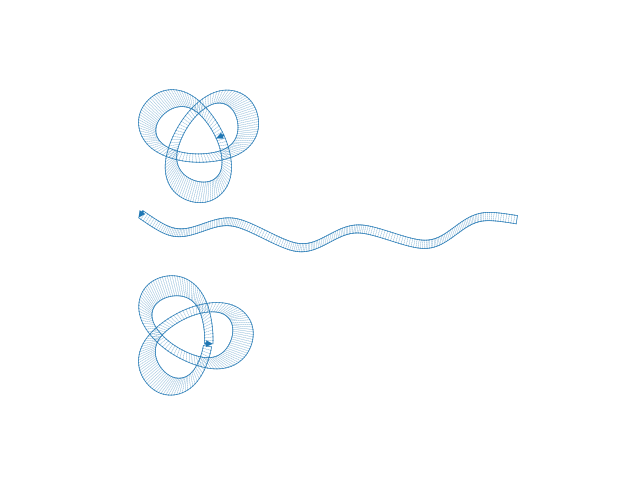

In [47]:
fig, ax = opt_prob.plot_unrolled_strips()

In [48]:
pkl_file = os.path.join(paths["output_opt"], "tube.pkl")
dill.dump(tube, open(pkl_file, "wb"))

## #4: Plane + Apex-Locating Function Optimzation ($\varphi^* = 360$˚)

In [ ]:
# Load the result of the previous optimization round
paths_load = setup_paths(get_name(), test_name="fig9_trefoil_360deg_planes")

pkl_file = os.path.join(paths_load["output_opt"], "tube.pkl")
tube = dill.load(open(pkl_file, "rb"))

In [68]:
paths = setup_paths(get_name(), test_name="fig9_trefoil_360deg_scale")

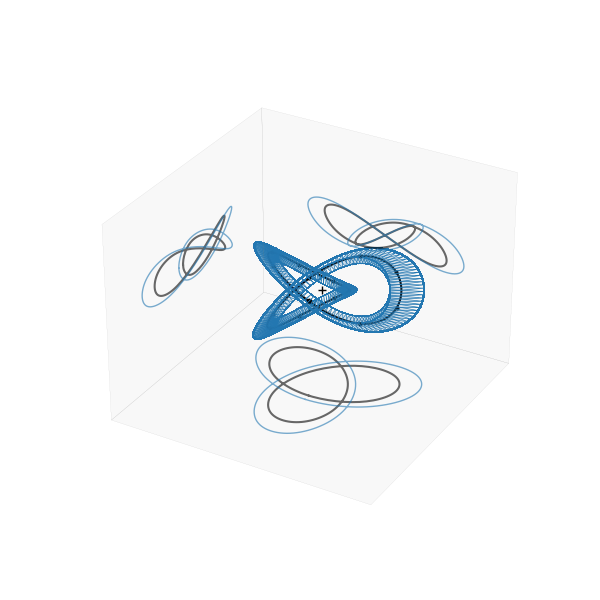

In [69]:
fig, ax = tube.plot_3d()

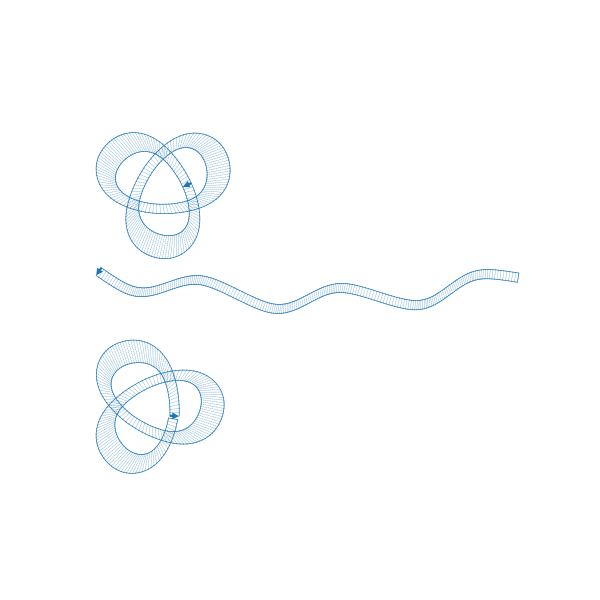

In [70]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [ ]:
# Uniform target cross-section radius
target_cross_section_radii = torch.ones(M) * tube_radius

# Set init scale to match the target cross-section radius
rad_0 = compute_cross_section_radii(tube.get_polyline_with_symmetry(), tube.compute_vertices_with_symmetry())[0]
init_scale_match_target = target_cross_section_radii[0] / rad_0
tube.set_init_scale(init_scale_match_target)
tube.update_ctube_vertices()

In [ ]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_section_radius': 5.25e1 / generatrix.aabb_diagonal_length() ** 2,
    'join_ends': 1e2 / generatrix.aabb_diagonal_length() ** 2,
    'smooth_plane_normal_diffs': 1e1,
}

objective_args = {
    'target_cross_section_radii': target_cross_section_radii,
    'join_ends_pairings': get_pairings_exact(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)
opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(True)
opt_prob.activate_plane_normals(True)

In [74]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_section_radius       : 3.5945278321
join_ends                               : 0.0000000475
smooth_plane_normal_diffs               : 0.0002720489
preserve_tube_ridge_edge_directions     : 0.0000000000
smooth_apex_loc_func                    : 0.0000000000
unitary_plane_normals                   : 0.0000009207


tensor(3.5948)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [76]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 1000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          260     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59480D+00    |proj g|=  1.58199D+01

At iterate    1    f=  3.21220D+00    |proj g|=  1.14950D+01

At iterate    2    f=  2.05000D+00    |proj g|=  5.95732D+00

At iterate    3    f=  8.51669D-01    |proj g|=  1.02937D+01

At iterate    4    f=  2.91217D-01    |proj g|=  1.72876D+00

At iterate    5    f=  1.69084D-01    |proj g|=  1.07168D+00

At iterate    6    f=  1.29932D-01    |proj g|=  2.51264D-01

At iterate    7    f=  1.20301D-01    |proj g|=  2.70656D-01

At iterate    8    f=  1.15906D-01    |proj g|=  2.90106D-01

At iterate    9    f=  1.00430D-01    |proj g|=  2.47026D-01

At iterate   10    f=  8.20259D-02    |proj g|=  1.72099D-01

At iterate   11    f=  7.78844D-02    |proj g|=  1.45217D-01

At iterate   12    f=  7.61595D-02    |proj g|=  5.28445D-01

At iterate   13    f=  7.4

In [77]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_section_radius       : 0.0001240862
join_ends                               : 0.0000042464
smooth_plane_normal_diffs               : 0.0012308725
preserve_tube_ridge_edge_directions     : 0.0000000000
smooth_apex_loc_func                    : 0.0000203411
unitary_plane_normals                   : 0.0000009934


tensor(0.0014)

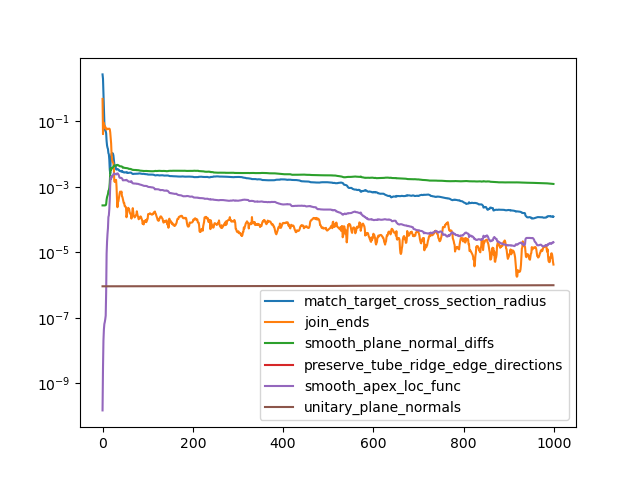

In [78]:
fig, ax = opt_prob.plot_objective_history()

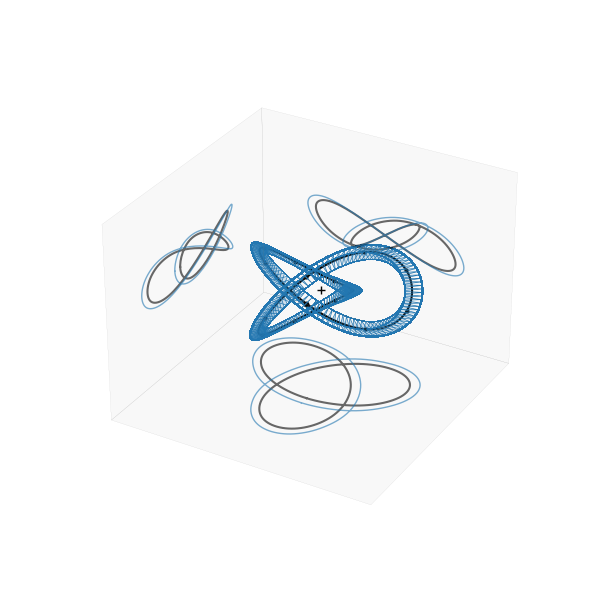

In [79]:
fig, ax = opt_prob.plot_3d()

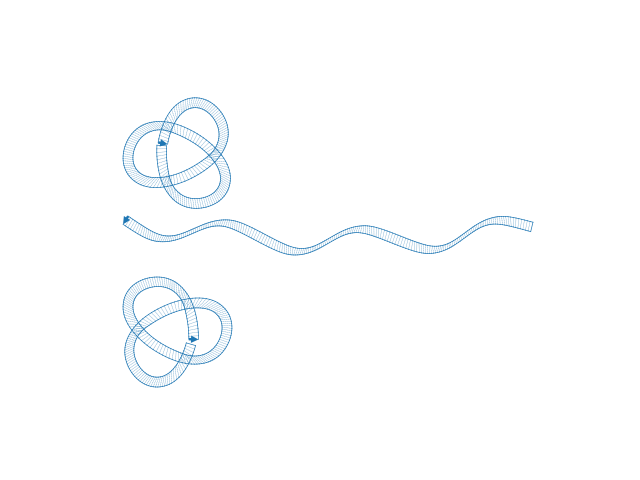

In [80]:
fig, ax = opt_prob.plot_unrolled_strips()

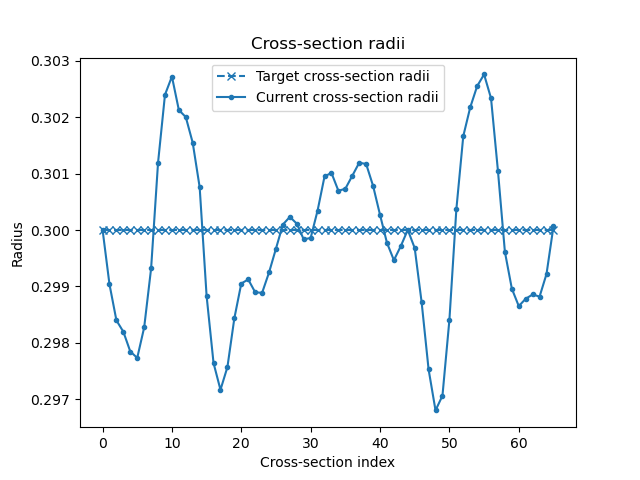

In [81]:
fig, ax = opt_prob.plot_cross_section_radii()